# Calculate phase dependent modulation of AP generation in response to spatially diffuse or concentrated poisson excitation and rhythmic inhibition

The simulations had either: 
1. Rhythmic inhibition at the soma (64 Hz) or dendrites (16 Hz) 
2. Diffuse or concentrated synaptic excitation at and dendrites

Here we calculate the cross-correlation between action potentials and input on spatially diffuse or concentrated synapses. These are stratified by:
1. Phase (peak or trough) of the inhibitory rhythm
2. Frequency of rhythm

The output of this script are...


In [1]:
import sys
import os
sys.path.append('..') # have to do this for relative imports in jupyter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.linear_model import LogisticRegression
from src.cc_presyn_phdep_files import cc_presyn_phdep_files
from src.load_spike_h5 import load_spike_h5
from src.load_spike_aux_h5 import load_spike_aux_h5
from src.cc_ptpt import cc_ptpt

### 1.1 Simulation constants and analysis windows

In [2]:
samps_per_ms = 10 # samples per millisecond
fs = 10000 # sampling frequency
sim_win = [0, 9000000] # beginning and start points of simulation in samples
cc_bin = samps_per_ms * 1 # bin size for cross-correlation in samples
cc_win_16 = [-499, 500] # number of lags for cross-correlation at 16 Hz inhibition
cc_win_64 = [-499, 500] # number of lags for cross-correlation at 64 Hz inhibition
cc_win_poiss = [-499, 500] # number of lags for cross-correlation with poisson inhibition

### 1.2 List files to be processed

In [3]:
# locate simulation files
dir_list = [{'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_conc_apical\\long',
             'InhibType': '16', 'ExcType': 'conc', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_conc_basal\\long',
             'InhibType': '16', 'ExcType': 'conc', 'ExcLoc': 'basal'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_diff\\long',
                'InhibType': '16', 'ExcType': 'diff', 'ExcLoc': 'apical'},
            #{'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_lessdiffuse_apical\\long',
            #    'InhibType': '16', 'ExcType': 'lessdiffuse', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_conc_apical\\long',
                'InhibType': '64', 'ExcType': 'conc', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_conc_basal\\long',
                'InhibType': '64', 'ExcType': 'conc', 'ExcLoc': 'basal'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_diff\\long',
                'InhibType': '64', 'ExcType': 'diff', 'ExcLoc': 'apical'},
            #{'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_lessdiffuse_apical\\long',
            #    'InhibType': '64', 'ExcType': 'lessdiffuse', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_conc_apical\\long',
                'InhibType': 'poiss', 'ExcType': 'conc', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_conc_basal\\long',
                'InhibType': 'poiss', 'ExcType': 'conc', 'ExcLoc': 'basal'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_diff\\long',
                'InhibType': 'poiss', 'ExcType': 'diff', 'ExcLoc': 'apical'},]
            #{'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_lessdiffuse_apical\\long',
            #    'InhibType': 'poiss', 'ExcType': 'lessdiffuse', 'ExcLoc': 'apical'}]

sim_df = pd.DataFrame(dir_list)

### 1.3 Generate inhibitory rhythm time series

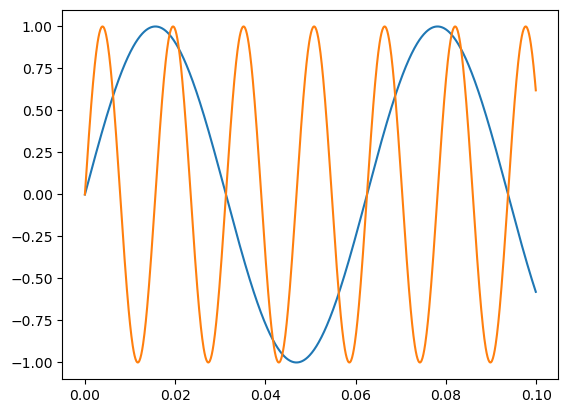

In [4]:
# generate phase time series for inhibitory afferents
t_ser = np.arange(sim_win[0], sim_win[1], 1) / fs # seconds
sin_16_ser = np.sin(t_ser*16*2*np.pi)
sin_64_ser = np.sin(t_ser*64*2*np.pi)

fig, ax = plt.subplots()
ax.plot(t_ser[0:1000],sin_16_ser[0:1000])
ax.plot(t_ser[0:1000],sin_64_ser[0:1000])
plt.show()

## 2.0 Phase startified cross-correlation between presynaptic spikes and action potentials

### 2.1 Calculate cross-correlations

In [5]:
def cc_func(sim_dir, inhib_type):
    # create full file path for presynaptic spike times and AP times, make OS independent
    presyn_file = os.path.join(sim_dir, 'exc_stim_aux_spikes2.h5')
    ap_file = os.path.join(sim_dir, 'spikes.h5')

    # calculate cross-correlation
    if inhib_type == '16':
        cc = cc_presyn_phdep_files(presyn_file, ap_file, sin_16_ser, cc_bin, cc_win_16, sm_win=1, notch_freq=16)
    elif inhib_type == '64':
        cc = cc_presyn_phdep_files(presyn_file, ap_file, sin_64_ser, cc_bin, cc_win_64, sm_win=1, notch_freq=64)
    elif inhib_type == 'poiss':
        spk_pts = load_spike_h5(ap_file)
        pre_pts = load_spike_aux_h5(presyn_file)
        cc = {'poiss': cc_ptpt(spk_pts, pre_pts, cc_bin, cc_win_poiss, 1)}
    return cc
    
# calculate cross-correlation for each simulation
sim_cc_df = sim_df.assign(AllCC = sim_df.apply(lambda x: cc_func(x['RootDir'], x['InhibType']), axis=1))

In [6]:
# breakout CC dictionaries
sim_cc_df = sim_cc_df.join(pd.DataFrame(sim_cc_df['AllCC'].tolist()))
sim_cc_df = pd.melt(sim_cc_df, id_vars=['RootDir', 'InhibType', 'ExcType', 'ExcLoc'],
                 value_vars=['t', 'p', 'poiss'], var_name='InhibPhase', value_name='CC')
sim_cc_df = sim_cc_df.dropna()
sim_cc_df = sim_cc_df.reset_index(drop=True)
sim_cc_df = sim_cc_df.join(pd.DataFrame(sim_cc_df['CC'].tolist()))
sim_cc_df.drop('CC', axis=1)

,RootDir,InhibType,ExcType,ExcLoc,InhibPhase,values,lags,ref_norm,values_corr
0,Z:\DendOscSub\output_clust_16Hz_conc_apical\long,16,conc,apical,t,"[1507.0, 1495.0, 1561.0, 1467.0, 1627.0, 1624....","[-499, -498, -497, -496, -495, -494, -493, -49...",0.000005,"[0.0021202595694511162, 0.0020311537959444115,..."
1,Z:\DendOscSub\output_clust_16Hz_conc_basal\long,16,conc,basal,t,"[1378.0, 1365.0, 1501.0, 1548.0, 1466.0, 1541....","[-499, -498, -497, -496, -495, -494, -493, -49...",0.000005,"[0.003911701233343677, -0.00036016599605360317..."
2,Z:\DendOscSub\output_clust_16Hz_diff\long,16,diff,apical,t,"[1107.0, 1125.0, 1170.0, 1272.0, 1238.0, 1329....","[-499, -498, -497, -496, -495, -494, -493, -49...",0.000005,"[0.0015483983059078772, -0.0004161365525189163..."
3,Z:\DendOscSub\output_clust_64Hz_conc_apical\long,64,conc,apical,t,"[1128.0, 1320.0, 1400.0, 1361.0, 1347.0, 1157....","[-499, -498, -497, -496, -495, -494, -493, -49...",0.000005,"[-0.0002544993377626082, 0.002260325007736326,..."
4,Z:\DendOscSub\output_clust_64Hz_conc_basal\long,64,conc,basal,t,"[1059.0, 1220.0, 1355.0, 1239.0, 1219.0, 1077....","[-499, -498, -497, -496, -495, -494, -493, -49...",0.000005,"[0.0014191139357869502, 0.0023718015457082874,..."
5,Z:\DendOscSub\output_clust_64Hz_diff\long,64,diff,apical,t,"[1166.0, 1219.0, 1436.0, 1423.0, 1379.0, 1259....","[-499, -498, -497, -496, -495, -494, -493, -49...",0.000005,"[0.0025695299266090543, 0.0016707579231963348,..."
6,Z:\DendOscSub\output_clust_16Hz_conc_apical\long,16,conc,apical,p,"[524.0, 484.0, 401.0, 382.0, 392.0, 365.0, 349...","[-499, -498, -497, -496, -495, -494, -493, -49...",0.000006,"[0.0009906384792812432, 0.001566111271245272, ..."
7,Z:\DendOscSub\output_clust_16Hz_conc_basal\long,16,conc,basal,p,"[552.0, 511.0, 505.0, 426.0, 428.0, 414.0, 381...","[-499, -498, -497, -496, -495, -494, -493, -49...",0.000006,"[0.0009768110037693745, 0.0008767853265392534,..."
8,Z:\DendOscSub\output_clust_16Hz_diff\long,16,diff,apical,p,"[447.0, 424.0, 354.0, 322.0, 319.0, 294.0, 212...","[-499, -498, -497, -496, -495, -494, -493, -49...",0.000006,"[0.0013382914456684695, 0.0012798975083991762,..."
9,Z:\DendOscSub\output_clust_64Hz_conc_apical\long,64,conc,apical,p,"[679.0, 490.0, 410.0, 345.0, 398.0, 599.0, 845...","[-499, -498, -497, -496, -495, -494, -493, -49...",0.000006,"[0.0016971377897374543, -0.002413676881796895,..."


In [7]:
# group by excitatory input type
exc_df = sim_cc_df.groupby(['ExcType', 'ExcLoc'])

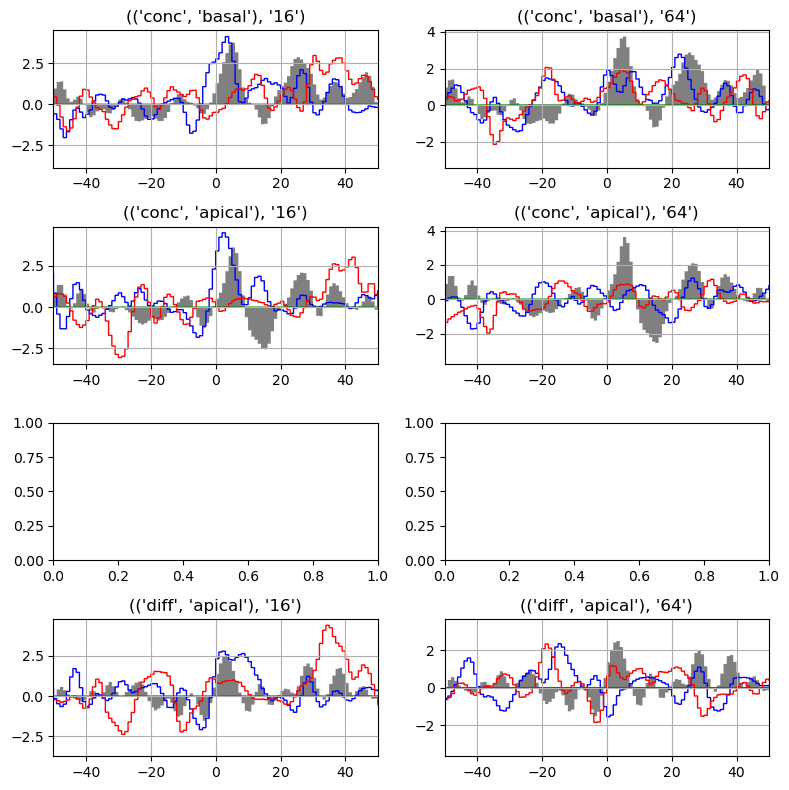

In [8]:
# plot corrected cross-correlations by excitatory input type
def plot_cc(sim_row, ax, **kwargs):
    # create gaussian convolution kernel
    sm_kern = np.hamming(9) # np.ones(1) # 
    sm_kern /= np.sum(sm_kern)
    sm_corr = np.convolve(sim_row['values_corr'].iloc[0][0:-1], sm_kern,'same')

    # z-transform sm_corr
    sm_corr -= np.mean(sm_corr)
    sm_corr /= np.std(sm_corr)
    #sm_corr -= np.mean(sm_corr)
    ax.stairs(sm_corr, sim_row['lags'].iloc[0], **kwargs)

def plot_cc_add(sim_row_t, sim_row_p, ax, **kwargs):
    # create gaussian convolution kernel
    sm_kern = np.hamming(9)
    sm_kern /= np.sum(sm_kern)
    sm_corr_t = np.convolve(sim_row_t['values_corr'].iloc[0][0:-1], sm_kern,'same')
    sm_corr_p = np.convolve(sim_row_p['values_corr'].iloc[0][0:-1], sm_kern,'same')
    #sm_corr -= np.mean(sm_corr)
    ax.stairs(sm_corr_t+sm_corr_p, sim_row_t['lags'].iloc[0], **kwargs)

def plot_exp(sim_set, exp_name, exp_freq, ax):
    plot_cc(sim_set[sim_set['InhibPhase']=='poiss'],ax, color='gray', fill=True)
    plot_cc(sim_set.loc[(sim_set['InhibPhase']=='t') & (sim_set['InhibType']==exp_freq)],ax, color='b')
    plot_cc(sim_set.loc[(sim_set['InhibPhase']=='p') & (sim_set['InhibType']==exp_freq)],ax, color='r')
    plot_cc_add(sim_set.loc[(sim_set['InhibPhase']=='t') & (sim_set['InhibType']==exp_freq)], 
                 sim_set.loc[(sim_set['InhibPhase']=='p') & (sim_set['InhibType']==exp_freq)],ax, color='g')
    ax.set_title((exp_name, exp_freq))
    #ax.set_ylim(-0.01,0.015)
    ax.set_xlim(-50,50)
    ax.grid(True)


fig,ax = plt.subplots(4,2)
plot_exp(exc_df.get_group(('conc', 'basal')), ('conc', 'basal'), '16',ax[0,0])
plot_exp(exc_df.get_group(('conc', 'basal')), ('conc', 'basal'), '64',ax[0,1])
plot_exp(exc_df.get_group(('conc', 'apical')), ('conc', 'apical'), '16',ax[1,0])
plot_exp(exc_df.get_group(('conc', 'apical')), ('conc', 'apical'), '64',ax[1,1])
#plot_exp(exc_df.get_group(('lessdiffuse', 'apical')), ('lessdiffuse', 'apical'), '16',ax[2,0])
#plot_exp(exc_df.get_group(('lessdiffuse', 'apical')), ('lessdiffuse', 'apical'), '64',ax[2,1])
plot_exp(exc_df.get_group(('diff', 'apical')), ('diff', 'apical'), '16',ax[3,0])
plot_exp(exc_df.get_group(('diff', 'apical')), ('diff', 'apical'), '64',ax[3,1])
fig.set_size_inches(8, 8)
fig.tight_layout()